# Zaman Serisi Analizi 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import math
from math import sqrt

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
# .csv dosyasının pandas read_csv metodu ile okunarak "data" adlı değişkene atanması: 

data = pd.read_csv("data.csv")

# veri setinin ilk beş elemanı: 
data.head()

,Tarih,Saat,T�ketim Miktar� (MWh)
0,01.01.2017,00:00,"27.223,06"
1,01.01.2017,01:00,"25.825,90"
2,01.01.2017,02:00,"24.252,68"
3,01.01.2017,03:00,"22.915,47"
4,01.01.2017,04:00,"22.356,99"


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51120 entries, 0 to 51119
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Tarih                  51120 non-null  object
 1   Saat                   51120 non-null  object
 2   T�ketim Miktar� (MWh)  51120 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [5]:
# veri setinin bir kopyasını oluturup "df" adlı bir değişkene atanması:

df = data.copy()

# kolon isimlerinin anlaşılır hale getirilmesi, tarih belirten kolonun datetime formatına çevrilmesi:

df['Tarih'] =pd.to_datetime(df['Tarih'] +' '+ df['Saat'], format='%d.%m.%Y %H:%M')

df = df.drop(columns = ["Saat"])
df = df.rename(columns={'T�ketim Miktar� (MWh)':'Tuketim'})

# tüketim değerlerini ifade eden "consumption" kolonundaki verilerin string tipinden float tipine dönüştürülmesi:

df['Tuketim'] = df['Tuketim'].str.replace('.', "" ,regex=True)
df["Tuketim"] = df["Tuketim"].str.replace(',', '.')
df["Tuketim"] = df["Tuketim"].astype(float)

df = df[["Tarih","Tuketim"]]

df.head()

,Tarih,Tuketim
0,2017-01-01 00:00:00,27223.06
1,2017-01-01 01:00:00,25825.90
2,2017-01-01 02:00:00,24252.68
3,2017-01-01 03:00:00,22915.47
4,2017-01-01 04:00:00,22356.99


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51120 entries, 0 to 51119
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Tarih    51120 non-null  datetime64[ns]
 1   Tuketim  51120 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 798.9 KB


In [7]:
# saatlik frekanstaki verilerin günlük frekansa çekilmesi,
# "Tarih" kolonunun indeks olarak verilmesi ve data_daily adlı değişkene atanması:
#Zaman Serisi verileriyle çalışacağımız için “Tarih” kolonunu da indeks olarak veriyoruz.

data_daily = df.set_index("Tarih").asfreq('D')
data_daily.head()

,Tuketim
Tarih,
2017-01-01,27223.06
2017-01-02,27477.70
2017-01-03,30859.74
2017-01-04,31313.51
2017-01-05,31433.88


In [8]:
data_daily.describe()

,Tuketim
count,2130.000000
mean,32653.296742
std,3321.932504
min,20627.680000
25%,30389.485000
50%,32360.350000
75%,34677.085000
max,44984.420000


In [9]:
# kayıp veri kontrolü :
# kayıp veri bulunmuyor


data_daily.isnull().sum()

Tuketim    0
dtype: int64

In [10]:
# yinelenen (duplike) veri kontrolü:
# 3 adet duplicate veri bulunmustur

duplicate = data_daily[data_daily.duplicated()]
 
print("Duplicate Rows :")
duplicate

Duplicate Rows :


,Tuketim
Tarih,
2019-01-06,30573.30
2019-01-26,31701.58
2022-01-10,32456.36


In [11]:
# duplike verilerin drop edilmesi: 

data_daily.drop_duplicates(inplace=True)

In [12]:
# duplike verilerin drop edilmesinden sonra tekrar kontrol edilmesi: 

duplicate = data_daily[data_daily.duplicated()]
 
print("Duplicate Rows :")
duplicate

Duplicate Rows :


,Tuketim
Tarih,


# Verilerin Çizgi grafiğinde gösterilmesi

### Gorsel olarak Trend ve Mevsimselik Tespiti

<AxesSubplot:xlabel='Tarih', ylabel='Tuketim'>

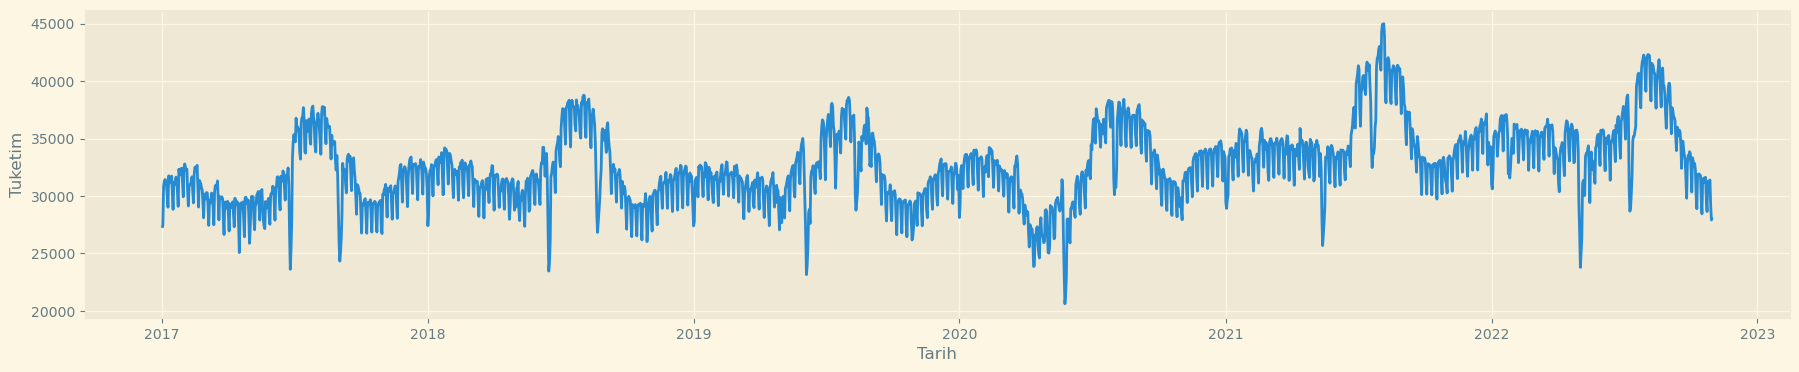

In [13]:
# verilerin çizgi grafiği üzerinde gösterilmesi:

plt.figure(figsize=(22,4))
sns.lineplot(data = data_daily.reset_index(), x="Tarih", y="Tuketim")

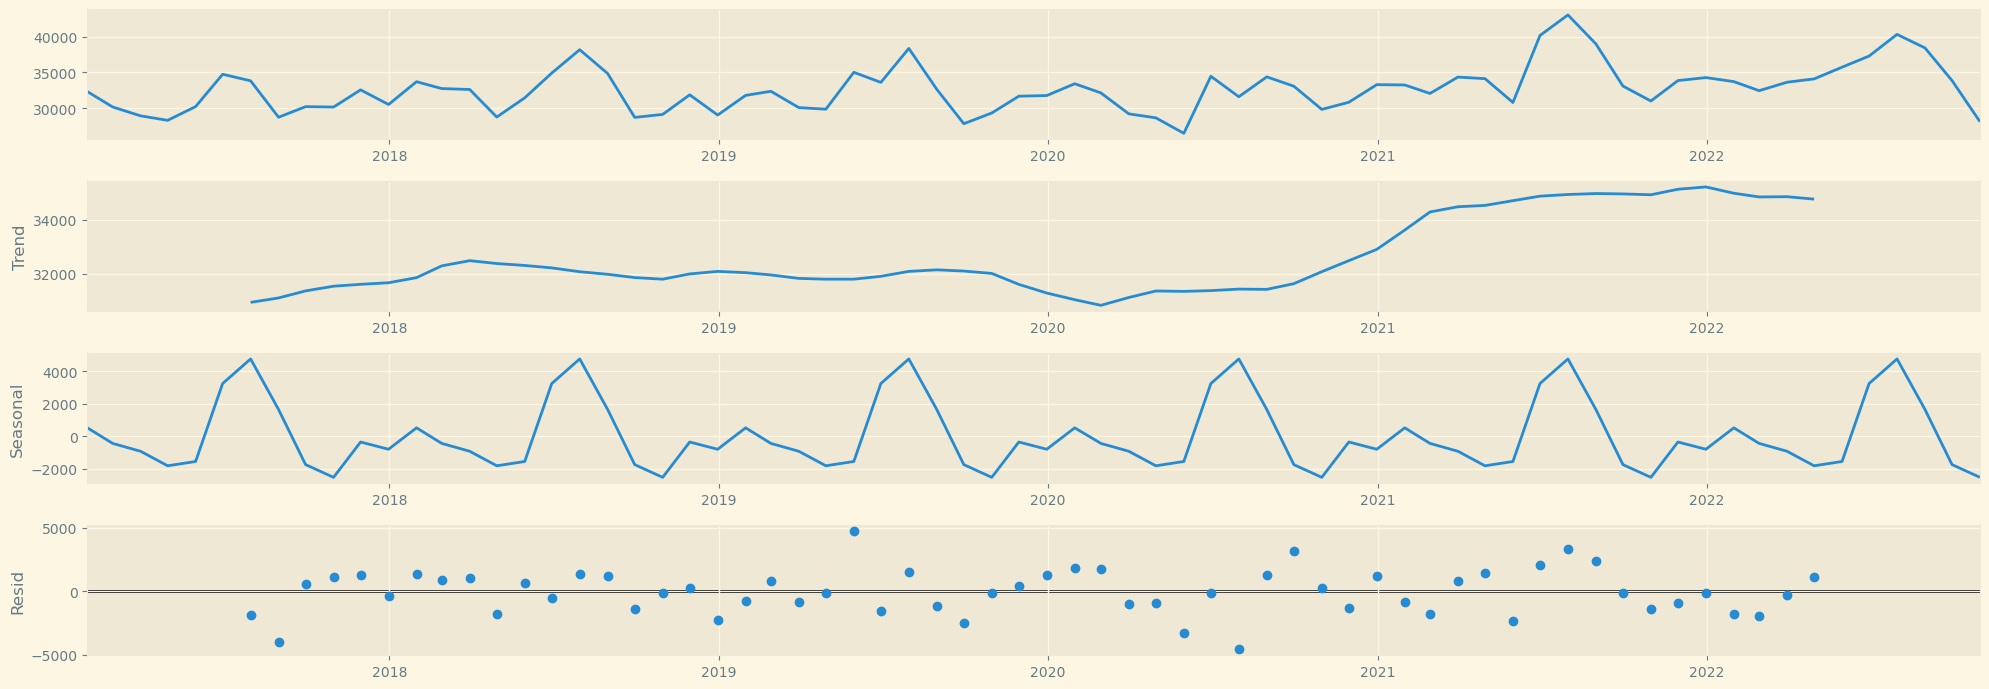

In [14]:
# zaman serisi bileşenleri: 

data_monthly = df.set_index("Tarih").asfreq('M')

plt.rcParams['figure.figsize'] = [20,7]
decomposition = sm.tsa.seasonal_decompose(data_monthly)
fig = decomposition.plot()
plt.show()


# alttaki grafk yorumu: elektrik tüketim verilerinin özellikle 2020 yılından sonra \\ 
# \\ genel bir pozitif eğilime ve mevsimselliğe sahip olduğunu söyleyebiliriz.
# Elektrik tüketim değerleri yaz aylarında zirve ve sonbaharda keskin bir düşüş yapar, \\
# \\ ardından kış mevsimine kadar hafif bir artış olur ve bahar mevsimi boyunca yavaş yavaş azalır.

# ACF ve PACF Grafikler

In [15]:
# VEriler durağan değilse bu garafiklerin kontrolü ile serinin durağanlığı hakkında çıkarımlar yapabiliriz
# Zaman serileri analizinde verilerin otokorelasyon ve kısmı otokorelasyon grafiğinin incelenmesi önemli bir adımdır. \\ 
# \\ Model terimlerinin sayısını belirlemek için Otokorelasyon fonksiyonu (ACF) ve kısmi otokorelasyon fonksiyonu (PACF) \\
# \\grafiklerinden yararlanacağız

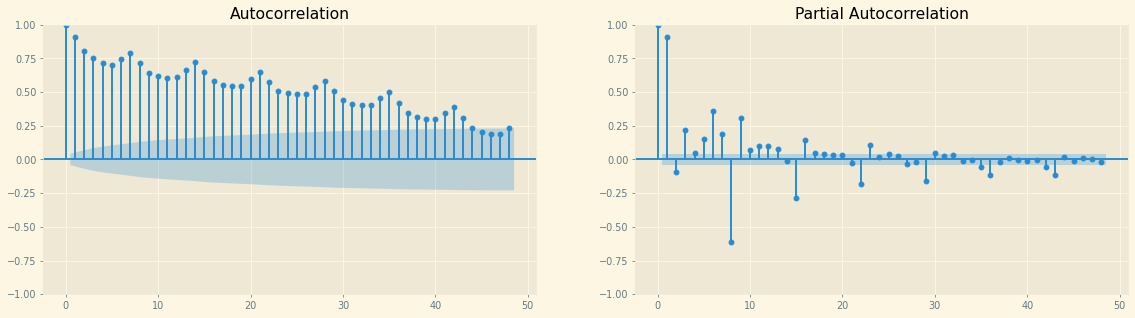

In [16]:
# otokorelasyon ve kısmı otokorelasyon grafikleri (ACF-PACF): 

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5), dpi= 70)

plot_acf(data_daily.Tuketim.tolist(), ax=ax1, lags=48)
plot_pacf(data_daily.Tuketim.tolist(), ax=ax2, lags=48, method="ywm")

plt.show()

In [17]:
# Verilerin çizgi grafiği, zaman serileri bileşenleri ve ACF-PACF grafiğinden yola çıkarak \\ 
# \\ serinin durağan olmadığını söyleyebiliriz.

Görsel olarak yapılan Durağanlık durumu için (Trend ve Mevsimsellikden dolayı) bu tespitlerini dogrulamak üzere Dickey-Fuller ve KPSS hipotez testleri kullanılır


1- Augmented Dickey-Fuller Test 
* Sıfır Hipotez H0 : Seri Durağan Değildir
* Alternati Hipotez H1 : Seri Durağandır (Birim Kök Yoktur)

2- Kwiatkowski-Phillips-Schmidt-Shin Test
* Sıfır Hipotez H0 : Seri Durağandır (Birim Kök Yoktur)
* Alternati Hipotez H1: Seri durağan değildir

In [18]:
# ADF Testi:

def adf(data):
    adf_test = sm.tsa.adfuller(data, autolag='AIC')
    print(f'ADF Statistic: {adf_test[0]}')
    print(f'p-value: {adf_test[1]}')
    print("Seri Durağan Değildir") if adf_test[1] > 0.05 else print("Seri Durağandır(Birim Kök Yoktur)")

# KPSS Testi:

def kpss(data):
    kpss_test = sm.tsa.kpss(data)
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print("Seri Durağandır") if kpss_test[1] > 0.05 else print("Seri durağan değildir(Seri Birim Kök İçerir)")

adf(data_daily)
print()
kpss(data_daily)

ADF Statistic: -3.7218103252720085
p-value: 0.003816624091614241
Seri Durağandır(Birim Kök Yoktur)

KPSS Statistic: 2.007418
p-value: 0.010000
Seri durağan değildir(Seri Birim Kök İçerir)


C:\Users\pc\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [19]:
# p-değerinin 0.05'ten (ve hatta 0.01'den) küçük olduğunu göz önünde bulundurarak, 
# bu zaman serisinin %95 (ve %99) güven seviyesinde durağan olduğunu söyleyebiliriz.
# ADF istatistiği negatif ise hipotez durağanlık lehine reddedilir.

In [20]:
# ADF testi bir birim kök bulamazsa, ancak KPSS testi bulursa, seri fark durağandır ve yine de fark alınması gerekir.

In [21]:
# Testlerden biri bile birim kökün varlığına işaret ediyorsa, seri durağandır diyemeyiz.

Alttaki bölümde: 
    Serinin durağan olmadığına emin olduktan sonra fark yöntemi ile serinin birinci dereceden farkını alarak serinin durağan hale gelip gelmediğini test edelim.
    Ayrıca başka metotlarda vardır. ders notunda bunlar belirtildi.

In [22]:
data_daily_diff = data_daily.copy()
data_daily_diff['Tuketim'] = data_daily['Tuketim'] - data_daily['Tuketim'].shift(1)
data_daily_diff = data_daily_diff.dropna()

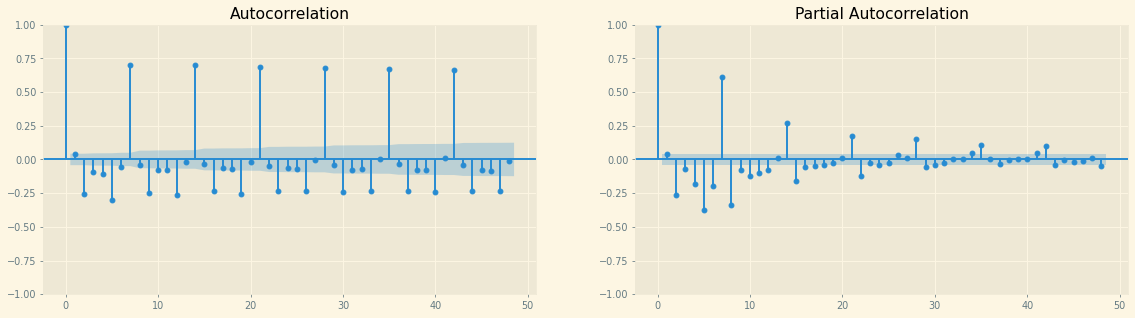

In [23]:
#  birinci dereceden farkı alınan serinin ACF ve PACF grafikleri:

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5), dpi= 70)

plot_acf(data_daily_diff.Tuketim.tolist(), ax=ax1, lags=48)
plot_pacf(data_daily_diff.Tuketim.tolist(), ax=ax2, lags=48, method="ywm")

plt.show()

In [24]:
#  birinci dereceden farkı alınan serinin ADF-KPSS testleri: 

adf(data_daily_diff)
print()
kpss(data_daily_diff)

ADF Statistic: -11.067211358999128
p-value: 4.649196734034982e-20
Seri Durağandır(Birim Kök Yoktur)

KPSS Statistic: 0.049428
p-value: 0.100000
Seri Durağandır


C:\Users\pc\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [25]:
#Serimiz artık durağan hale gelmiş olsa bile hala ACF grafiğinde dalgalanmalar yani mevsimselliğin olduğunu ve gecikme sayılarının tekrarlarını incelediğimiz zaman \\
# \\ periyodun 7 olduğunu tespit edebiliyoruz. Ayrıca PACF’deki 7. gecikmenin de sınırlar dışında kaldığını görüyoruz.

In [26]:
# Periyot 7 olarak belirledikten sonra birinci dereceden mevsimsel fark alıyoruz:
# birinci dereceden farkı alınan seri üzerinde mevsimsel fark uygulanması: 

data_daily_diff2 = data_daily_diff.diff(7).dropna()

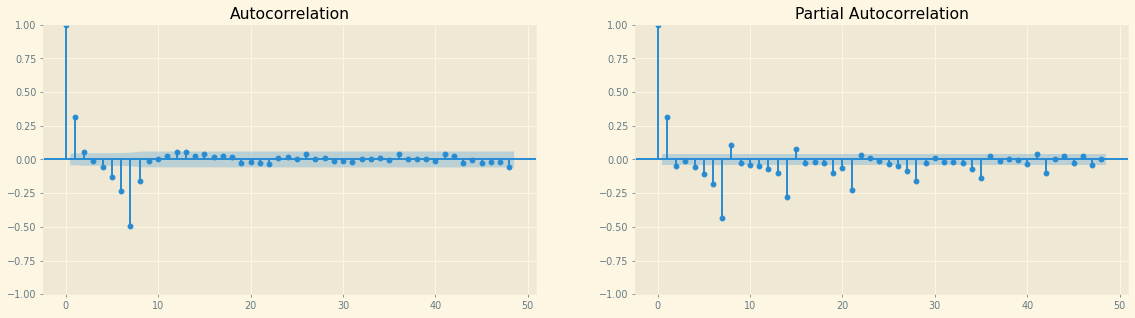

In [27]:
#  ACF ve PACF plot

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5), dpi= 70)

plot_acf(data_daily_diff2.Tuketim.tolist(), ax=ax1, lags=48)
plot_pacf(data_daily_diff2.Tuketim.tolist(), ax=ax2, lags=48)

plt.show()

Yukardaki işlemler sonucunda böylece serimizi trend ve mevsimsel etkiden arındırmayı başardık.

# Modelleme Aşaması

 Modelleme aşamasına geçmeden önce, yaptığımız analizler doğrultusunda model parametrelerini manuel olarak belirleyemeye çalışalım.
 

Hem trend hem mevsimsel fark alınarak durağan hale geldiği için d = 1 ve D = 1 şeklinde tanımlayacağız.

ACF grafiğinde 1,2 ve 7' de önemli bir gecikme vardır. Bu nedenle MA(q) parametresi 2 ve mevsimsel MA(Q) parametresi 1 olabilir.

PACF grafiğinde ise 1,2 ve 7,14,21’de önemli bir gecikme vardır. AR(p) parametresi 2 olabilir. Mevsimsel AR(P) parametresinin ise aslında bu durumda 0 alınması tavsiye ediliyor.

Bazı kaynaklarda, mevsimsel gecikmedeki otokorelasyon negatifse, modele mevsimsel MA(Q) terimi eklenip mevsimsel AR(P) teriminin atlanması yani 0 alınması öneriliyor. Fakat   denemelerde AR(P)=1 almak daha düşük hata oranı ve yüksek R Kare değeri verdiği için biz burada AR(P) terimini 1 olarak alacağız.

Buradan yola çıkarak;

ARIMA(2,1,2) ve SARIMA(2,1,2)x(1,1,1,7) olacak şekilde notasyonumuzu oluşturuyoruz.

In [28]:

# veri setinin eğitim ve test seti olarak ayrıştırılması : 
# 1 Ocak 2017 - 31 Temmuz 2022 eğitim seti, 1 Ağustos 2022 - 31 Ağustos 2022 ise test seti olacak şekilde ayırıyoruz. 

train_data = data_daily[:'2022-07-31']
test_data = data_daily['2022-08-01':'2022-08-31']
pred_df = test_data.copy()

Her model için aynı aralıkta bir tahminleme işlemi yapacağız sonrasında sonuçları test setindeki gerçek değerler ile karşılaştıracağız.

## ARIMA modellemesi

In [29]:
#ARIMA(2,1,2) modelini statsmodels paketini kullanarak oluşturalım ve belirlediğimiz aralık için bir tahminleme \\
# \\ gerçekleştirelim. Ardından gerçek değerler ile tahmin edilen değerleri bir görsel üzerinde gösterelim.

<AxesSubplot:xlabel='Tarih'>

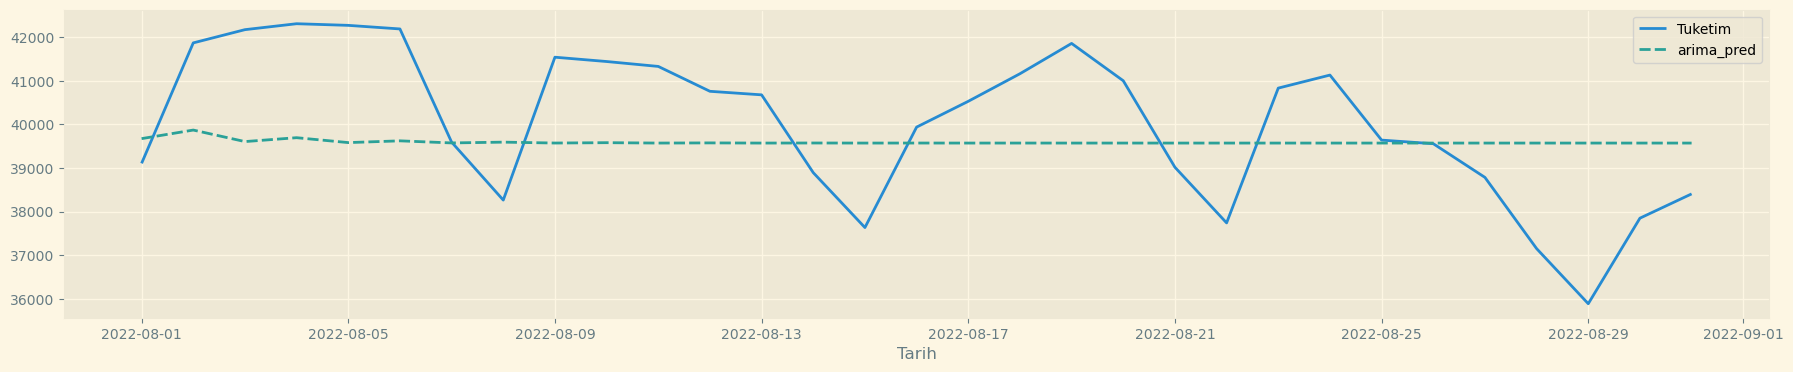

In [30]:
# ARIMA (2,1,2)
#Verileri eğitim ve test seti olarak ikiye ayırıyoruz

arima_model = sm.tsa.arima.ARIMA(np.asarray(train_data),order=(2,1,2))
arima_model_fit = arima_model.fit()
arima_pred = arima_model_fit.forecast(len(test_data),disp=False)

pred_df["arima_pred"] = arima_pred.round(2)
plt.figure(figsize=(22,4))
sns.lineplot(data = pred_df[['Tuketim', 'arima_pred']])

ARIMA modeli grafikten anlayacağımız üzere pek iyi çalışmadı çünkü verilerimiz mevsimsellik içeriyor ve ARIMA tarafından iyi tahmin edilemiyor. Bu tür durumlarda daha önceki yazımda bahsettiğim gibi SARIMA modeli daha iyi çalışacaktır

 ## SARIMA Modellemesi

aynı tahmin işlemini SARIMA üzerinde gerçekleştirelim. 
SARIMA (2,1,2) (1,1,1,7)

C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:xlabel='Tarih'>

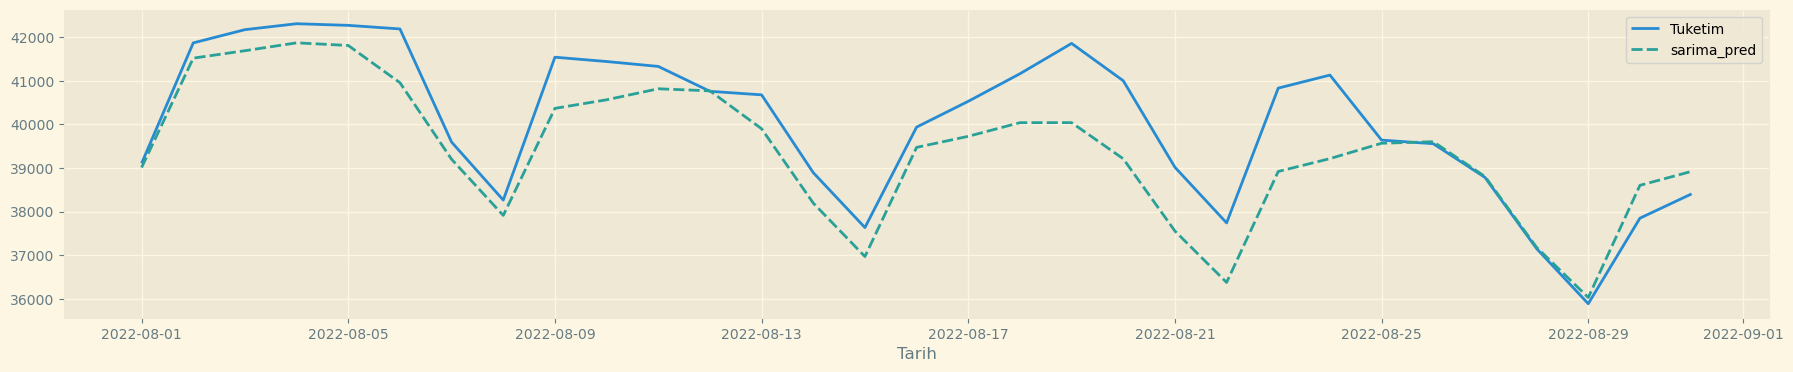

In [31]:
# SARIMA (2,1,2) (1,1,1,7)

sarima_model = SARIMAX(np.asarray(train_data), order=(2, 1, 2), seasonal_order=(1,1,1,7))
sarima_model_fit = sarima_model.fit()
sarima_pred = sarima_model_fit.forecast(len(test_data))

pred_df["sarima_pred"] = sarima_pred.round(2)
plt.figure(figsize=(22,4))
sns.lineplot(data = pred_df[['Tuketim', 'sarima_pred']])

In [32]:
# SARIMA modelinin ARIMA modelinden daha iyi sonuç verdiğini grafikten gözlemleyebiliyoruz.

## PROPHET Modellemesi

In [33]:
# Prophet algoritması girdi olarak “ds” ve “y” değişkenleriyle çalıştığı için eğitim ve test setimizi buna göre ayarlıyoruz

ds:  Bu sütun, tarihleri içerir. Prophet için bu sütunda olan tarihler genellikle günlük frekansta olmalıdır, ancak bu zorunlu değildir. Tarihler YYYY-MM-DD biçiminde (örneğin "2021-01-01") ya da zaman damgası (timestamp) biçiminde olabilir.

y: Bu sütun, tahmin etmek istediğiniz gözlemlenen değerleri içerir. Örneğin, bir web sitesinin günlük ziyaretçi sayısını tahmin etmek istiyorsanız, y sütunu bu ziyaretçi sayılarını içerecektir.

00:08:10 - cmdstanpy - INFO - Chain [1] start processing
00:08:11 - cmdstanpy - INFO - Chain [1] done processing


<AxesSubplot:xlabel='Tarih'>

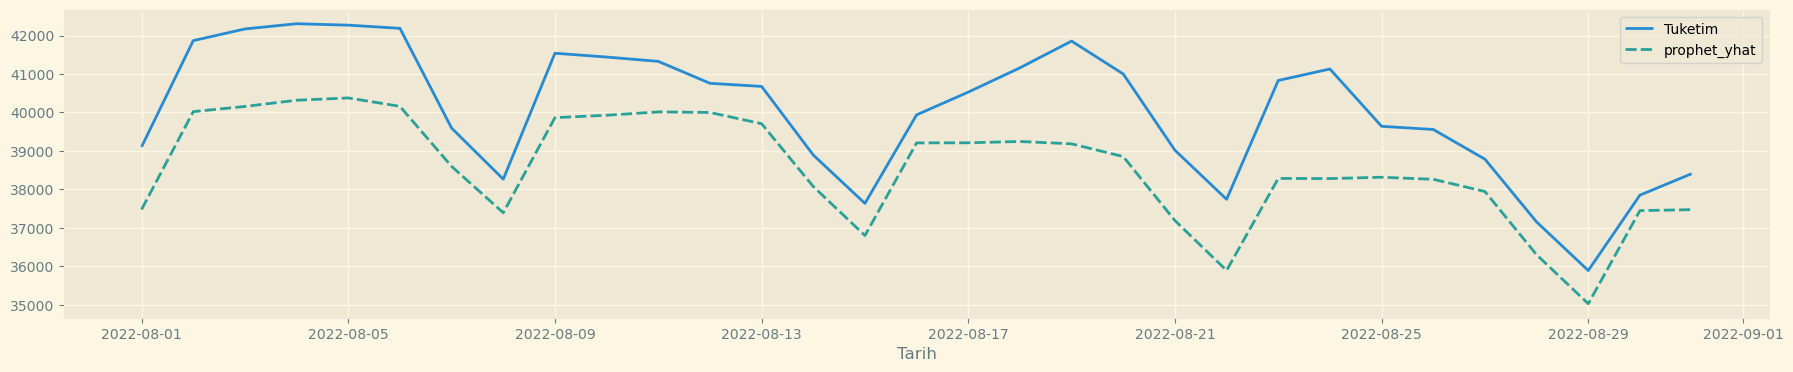

In [34]:
# PROPHET

prophet_df = data_daily.reset_index()
prophet_df.columns = ["ds","y"]

train_data_prophet = prophet_df[prophet_df['ds'] < '2022-08-01']
test_data_prophet = prophet_df[(prophet_df['ds'] >= '2022-08-01') & (prophet_df['ds'] <= '2022-08-31')]

prophet_model = Prophet()
prophet_model.fit(train_data_prophet)
model_predict = prophet_model.predict(test_data_prophet)

pred_df["prophet_yhat"] = model_predict["yhat"].values.round(2)
pred_df["prophet_yhat_lower"] = model_predict["yhat_lower"].values.round(2)
pred_df["prophet_yhat_upper"] = model_predict["yhat_upper"].values.round(2)

plt.figure(figsize=(22,4))
sns.lineplot(data = pred_df[['Tuketim', 'prophet_yhat']])

In [35]:
# altta ise yhat, yhat_lower ve yhat_upper değerlerini içeren grafik gorunuyor

yhat: Bu, modelin tahmin ettiği ana değerdir. Diğer bir deyişle, bu değer modelinizin belirli bir ds (tarih) değeri için zaman serisinin ne olacağını tahmin ettiği değerdir.

yhat_lower ve yhat_upper: Bu değerler, tahminlerin belirsizlik aralığını ifade eder. Prophet, tahminlerini oluştururken belirsizliği de dikkate alarak, gerçek değerin bu aralık içerisinde olma olasılığını yüksek bir güvenle tahmin eder. Örneğin, eğer yhat_lower 50 ve yhat_upper 60 ise, bu modelin gerçek değerin bu aralıkta olacağını yüksek bir güvenle tahmin ettiği anlamına gelir.

<AxesSubplot:xlabel='Tarih'>

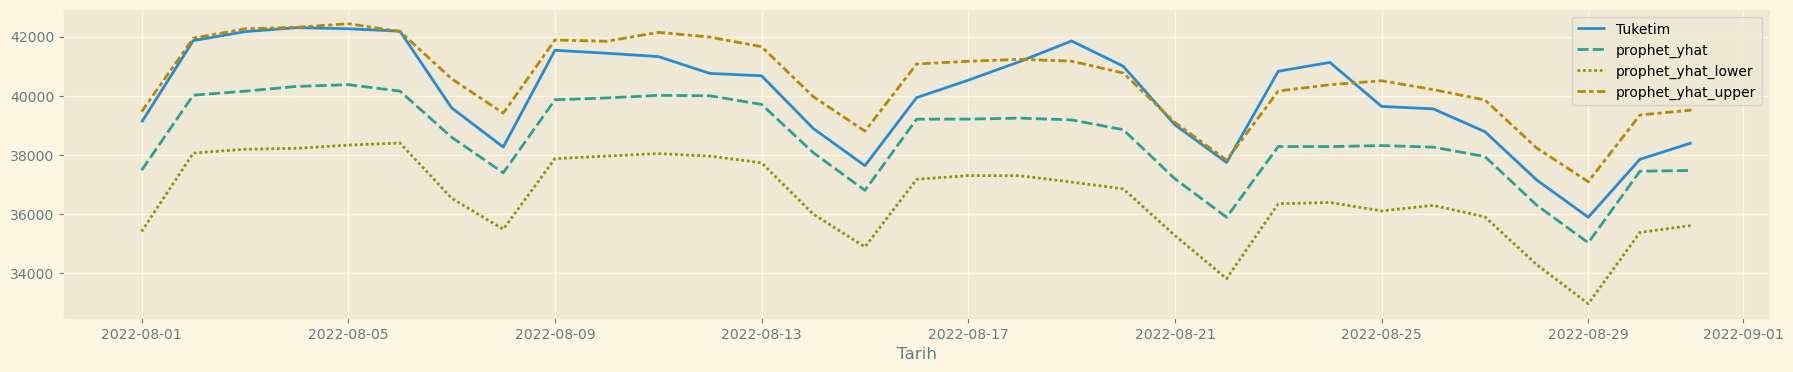

In [36]:
plt.figure(figsize=(22,4))
sns.lineplot(data = pred_df[['Tuketim', 'prophet_yhat', 'prophet_yhat_lower','prophet_yhat_upper']])

# Model Evaluation

In [37]:
# Modeli değerlendirmek için MAE, RMSE ve R2 metriklerini kullanacağız

In [38]:
prophet_mape = mean_absolute_percentage_error(pred_df["Tuketim"].values, pred_df["prophet_yhat"].values)
prophet_r = r2_score(pred_df["Tuketim"].values, pred_df["prophet_yhat"].values)
prophet_rmse = math.sqrt(mean_squared_error(pred_df["Tuketim"].values, pred_df["prophet_yhat"].values))

arima_mape = mean_absolute_percentage_error(pred_df["Tuketim"].values, pred_df["arima_pred"].values)
arima_r = r2_score(pred_df["Tuketim"].values, pred_df["arima_pred"].values)
arima_rmse = math.sqrt(mean_squared_error(pred_df["Tuketim"].values, pred_df["arima_pred"].values))

sarima_mape = mean_absolute_percentage_error(pred_df["Tuketim"].values, pred_df["sarima_pred"].values)
sarima_r = r2_score(pred_df["Tuketim"].values, pred_df["sarima_pred"].values)
sarima_rmse = math.sqrt(mean_squared_error(pred_df["Tuketim"].values, pred_df["sarima_pred"].values))

results = {'Prophet': [prophet_mape,prophet_rmse,prophet_r], 
        'ARIMA': [arima_mape,arima_rmse,arima_r],
        'SARIMA': [sarima_mape,sarima_rmse,sarima_r]}
results = pd.DataFrame(results,index=['MAE','RMSE','R2'])
results

,Prophet,ARIMA,SARIMA
MAE,0.036340,0.037491,0.018154
RMSE,1595.779817,1735.551083,938.289676
R2,0.118468,-0.042718,0.695234


## Sonuçlar

Örneğimizde ARIMA modelinin R Kare değeri -0.042 gibi negatif bir değer çıkmıştır. Bu da demek oluyor ki model gerçekten de verilerimiz için uygun değil.

İlgili dönem aralığındaki model performans sonuçlarında SARIMA modeli en düşük RMSE ve MAPE değerine sahip olmakla birlikte R Kare skoru 0,66'dır ve bu, modellerimiz arasında en yüksek puandır.

Sonuçlar aslında şaşırılacak şekilde iyi görünüyor? Rastgele bir doğrulama dönemi seçerek bir dizi tek adımlı tahmin yaptık. Bu oluşturulan modellerin, geleceğe yönelik birçok dönemi doğru bir şekilde tahminleyeceği anlamına gelmez. Yani etkili bir zaman serisi modelini bulmak ve doğrulamak aslında bu kadar basit değil.

Burada çok temel şekilde modellerimizi oluşturduk ve hiperparametre ayarlamalarını yapmadık

SARIMA ve Prophet modellerinin geliştirilmesi ve hata oranlarının düşürülmesi için doğru şekilde veri setinin ayrıştırılması, parametre optimizasyonu, anlamlı bağımsız değişkenlerin modele eklenmesi, tatil günlerinin ayrıştırılması gibi yapabileceğiniz birçok şey vardır.

